To do:
 - tidy up code
 - add more comments, add docstrings 
 - tidy up 'visualise', remove loops etc. 
 - create class for data analysis - dictionary of dataframes
 - create visualise data function 
 - add 'Protein' column

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import string, math
from platemapping import plate_map as pm

In [41]:
wells = {6:(2, 3), 12:(3, 4), 24:(4, 6), 48:(6, 8), 96:(8, 12), 384:(16, 24)} 


In [43]:
def read_in(raw_data):
    """returns a dataframe of the flex data"""
    df = pd.read_csv(raw_data, delimiter='\t', skiprows = 2, skipfooter=3, engine = 'python', encoding = 'mbcs') 
    return df

class CaFlexAnalysis:

    def __init__(self, raw_data, plate_map_file, map_type = 'short', data_type = 'old', valid = True, size = 96):
        self.raw_data = raw_data
        self.plate_map_file = plate_map_file
        self.map_type = map_type
        self.size = size
        self.data_type = data_type
        self.valid = valid
        
    def give_platemap(self):
        """returns platemap dataframe"""
        if self.map_type == 'short':
             platemap = pm.short_map(self.plate_map_file, size = self.size, valid = self.valid)
        elif self.map_type == 'long':
            platemap = pm.plate_map(self.plate_map_file, size = self.size, valid = self.valid)
        return platemap
    
    def data_processed(self):
        """returns a timemap and datamap as a tuple"""
        platemap = self.give_platemap()
        
        df = read_in(self.raw_data)
        # create new dataframe containing all time values for each well
        dftime = df.filter(regex = 'T$', axis = 1)
        
        # edit header names (this will come in handy in a second)
        dftime.columns = dftime.columns.str.replace('T', "")
        
        # extract list of header names 
        wellslist = list(dftime.columns.values)
        
        # transpose x and y axes of dataframe - generate time 'rows'
        dftime = dftime.transpose()
        
        # join time rows to plate map, generating plate map that contains time values
        timemap = platemap.join(dftime)

        # create new dataframe containing data measurements for each cell
        dfdata = df[wellslist]
        
        # transpose x and y axes
        dfdata = dfdata.transpose()
        
        # join to plate map 
        datamap = platemap.join(dfdata)

        # return timemap and datamap as a tuple
        return {'times':timemap, 'data':datamap}


In [59]:
# text file to be read in
datafile = '14052019 C5sYFP2 IBP21 inhib 300nM to 0.3 nM.txt' 

# corresponding map inputted by user
mapcsv = 'shortmap_example.csv' 
flex = CaFlexAnalysis(raw_data = datafile, plate_map_file = mapcsv)

#def plot_data(caflexclass):
    # extract times for each well to plot
dfs = flex.data_processed()
times = dfs['times']
times = times.iloc[:, 10:]

# extract data for each well to plot
data = dfs['data']
data = data.iloc[:, 10:]



In [132]:
# fontsize will scale font size of visualisaiton to the well plate size (avoids overlapping text)
def fontsize(sizeby, size): 
    """returns a font size defined by the length of the string and size of the well plate
    (larger well plate and/or longer string = smaller font size."""
    return (8 - math.log10(len(str(sizeby)))*2 - math.log10(size)*1.5)

# adds labels according to label stipulations (avoids excessive if statements in the visualise function)
def labelwell(platemap, labelby, iterrange):
    """returns label for each row of a stipulated column"""
    if platemap['Type'].iloc[iterrange] == 'empty':
        return "empty"
    else:
        return str(platemap[labelby].iloc[iterrange]).replace(" ", "\n")
    
def wellcolour(platemap, colorby, colormap, iterrange):
    """returns a unique colour for each label or defined condition"""
    # unique strings in the defined column are used as the list of labels, converted to strings to avoid errors.
    types = [str(i) for i in list(platemap[colorby].unique())]
    cmap = plt.get_cmap(colormap)
    # get equally spaced colour values
    colors = cmap(np.linspace(0, 1, len(types)))
    colordict = dict(zip(types, colors))
    colordict['nan'] = 'yellow'
    color = colordict.get(str(platemap[colorby].iloc[iterrange]))
    return color

def visualise_data(caflexclass, title = "", export = False, colormap = 'Dark2_r',
             colorby = 'Type', labelby = 'Type', dpi = 200):
    """returns a visual representation of the platemap"""
    
    size = caflexclass.size
    platemap = caflexclass.give_platemap()
    
    # extract times for each well to plot on x axis
    dfs = caflexclass.data_processed()
    times = dfs['times']
    times = times.iloc[:, 10:]

    # extract data for each well to plot on y axis
    data = dfs['data']
    data = data.iloc[:, 10:]

    fig = plt.figure(dpi = dpi)
    # define well plate grid according to size of well plate 
    # an extra row and column is added to the grid to house axes labels
    grid = gridspec.GridSpec((wells[size])[0]+1, (wells[size])[1]+1, wspace=0.1, hspace=0.1, figure = fig)

    # plot row labels in extra row
    for i in range(1, (wells[size])[0]+1):
        ax = plt.subplot(grid[i, 0])
        ax.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.text(0.5, 0.5, list(string.ascii_uppercase)[i-1], size = 10, ha = "center", va="center")
        
    # plot column labels in extra column
    for i in range(1, (wells[size])[1]+1):
        ax = plt.subplot(grid[0, i])
        ax.axis('off')
        ax.text(0.5, 0.5, list(range(1, (wells[size])[1]+1))[i-1], size = 8, ha = "center", va="center")
        
    # plot plate types in grid, color code and label
    for i in range(size):
            # color code
        ax = plt.subplot(grid[(ord(platemap['Row'].iloc[i].lower())-96), ((platemap['Column'].iloc[i]))])
        ax.axis('off')
        ax.plot(times.iloc[i], data.iloc[i], lw = 0.5, color = wellcolour(platemap, colorby, colormap, i), 
                label = labelwell(platemap, labelby, i))
        # add label for each well
        legend = ax.legend(loc = 'lower center', fontsize = str(fontsize(sizeby = platemap[labelby].iloc[i], size = size)),
                 frameon = False, markerscale = 0)
        
        # remove legend line (keeps just text)
        for item in legend.legendHandles:
            item.set_visible(False)
    fig.suptitle('{}'.format(title))
    
    # provides option to save well plate figure 
    if export == True:
        plt.savefig('{}_map.png'.format(title))
    else:
        pass

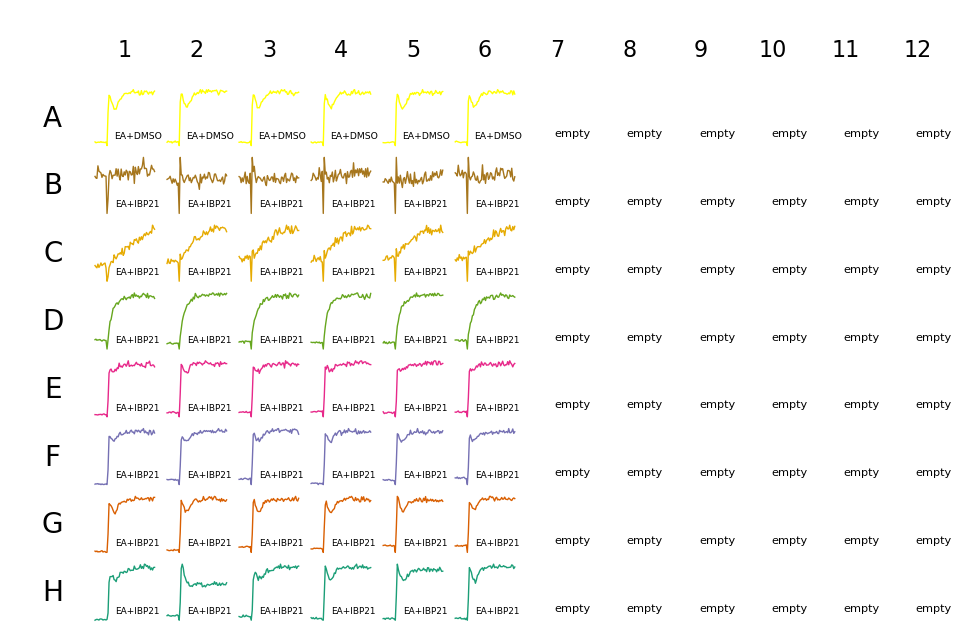

In [135]:
visualise_data(flex, labelby = 'Contents', colorby = 'Concentration')